<a href="https://colab.research.google.com/github/hsym-uec/myWeb_github/blob/main/Simmple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
# Nintendo Stock data from Stooq.com 7974.JP
# reference https://seanmemo.com/234/

import subprocess
from subprocess import PIPE
from PIL import Image
import tkinter as tk
import tkinter.ttk as ttk
import mplfinance as mpf
import datetime
from datetime import timedelta
from pandas_datareader import data
import pandas as pd
global tree
global df
global stdata
stdata = pd.read_csv(filepath_or_buffer="data.csv", encoding="shift-jis", sep=",")
global DaysList
DaysList = pd.read_csv(filepath_or_buffer="DaysList.csv", encoding="shift-jis", sep=",")
global date

def btn_click():
    global df
    global stdata
    global DaysList
    global date

    #入力を受け取る
    code = stdata[stdata["name"] == variable1.get()]["code"].to_string(index=False)
    #code = txt1.get()   
    days = DaysList[DaysList["disp"] == variable2.get()]["num"].to_string(index=False)
    #days = txt2.get()
    #days = input("範囲指定:")
    date = stdata[stdata["name"] == variable1.get()]["date"].to_string(index=False)

    #stooqからデータ取得
    today = datetime.date.today()
    start = today - timedelta(float(days))
    end = today
    df = data.DataReader(code, 'stooq', start, end)

    #グラフ表示
    window = tk.Toplevel()
    window.geometry("800x575")
    window.title(variable1.get() + "    範囲：" + variable2.get())

    fig = 'fig/test.png'
    # イメージ作成
    dfs = df.sort_index()
    mpf.plot(dfs,type='candle',mav=(3, 6, 9),volume=True,savefig=fig)
    img = Image.open(fig)
    h = img.height
    w = img.width
        
    # キャンバス作成
    canvas = tk.Canvas(window, bg="white", height=h, width=w)
    # キャンバス表示
    canvas.place(x=0, y=0)
    # キャンバスにイメージを表示
    img = tk.PhotoImage(file=fig)
    canvas.create_image(0, 0, image=img, anchor=tk.NW)
    
    window.mainloop()


def selected(event):
    for item in tree.selection():
        print(item, tree.item(item))

def change_table():
    global tree
    # Load .csv
    df = pd.read_csv("data.csv", encoding='shift-jis')
    # create Window and Treeview
    table = tk.Tk()
    tree = ttk.Treeview(table, show='headings')
    # set Treeview columns
    tree['column'] = ("No",) + tuple(df)
    # set header
    tree.heading("No", text="No")
    for c in df:
        tree.heading(c, text=c)
    # set cells on the row
    for i, row in enumerate(df.itertuples()):
        tree.insert("", "end", tags=i, values=row)
    # set layout
    tree.pack()
    # bind action
    tree.bind('<<TreeviewSelect>>', selected)
    btn3 = tk.Button(table,text='グラフ表示')
    btn3.pack(side=tk.BOTTOM, fill=tk.X)
    # set loop
    root.mainloop()
    
def change_table2():
    proc = subprocess.run(['python', 'csvcontrol.py'], stdout=PIPE, stderr=PIPE)


def load():
    global stdata
    stdata = pd.read_csv(filepath_or_buffer="data.csv", encoding="shift-jis", sep=",")
    global opt1
    opt1.destroy()
    opt1 = tk.OptionMenu(root, variable1, *stdata["name"])
    opt1.config(width=20)
    #opt1.pack()
    opt1.place(x=80, y=70)

    
#ウィンドウ表示
root = tk.Tk()
root.title("株価表示")
root.geometry("300x200")

#テキスト
#lbl1 = tk.Label(text='銘柄追加')
#lbl1.place(x=30, y=40)
lbl2 = tk.Label(text='銘柄：')
lbl2.place(x=30, y=70)
lbl3 = tk.Label(text='範囲：')
lbl3.place(x=30, y=100)

#テキストボックス
#txt1 = tk.Entry(width=20)
#txt1.place(x=80, y=40)
#txt2 = tk.Entry(width=20)
#txt2.place(x=80, y=100)

#プルダウン
variable1 = tk.StringVar(root)
global opt1
opt1 = tk.OptionMenu(root, variable1, *stdata["name"])
opt1.config(width=20)
#opt1.pack()
opt1.place(x=80, y=70)

variable2 = tk.StringVar(root)
opt2 = tk.OptionMenu(root, variable2, *DaysList["disp"])
opt2.config(width=20)
#opt2.pack()
opt2.place(x=80, y=100)

#ボタン
btn = tk.Button(text='グラフ表示', command=btn_click)
btn.pack(side=tk.BOTTOM, fill=tk.X)
btn2 = tk.Button(text='銘柄確認', command=change_table2)
btn2.place(x=30,y=30)
btn3 = tk.Button(text='更新', command=load)
btn3.place(x=120,y=30)
btn4 = tk.Button(text='利益', command=btn_click)
btn4.pack(side=tk.BOTTOM, fill=tk.X)

root.mainloop()

In [153]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-19,6250,6259,6169,6232,3490000
2023-06-16,6200,6277,6149,6266,6516500
2023-06-15,6200,6357,6197,6225,7487200
2023-06-14,6190,6192,6137,6157,3752400
2023-06-13,6159,6194,6127,6181,3726900
...,...,...,...,...,...
2023-01-27,5660,5669,5617,5630,2678500
2023-01-26,5602,5660,5602,5635,3524000
2023-01-25,5567,5591,5545,5574,3152700


<Axes: xlabel='Date'>

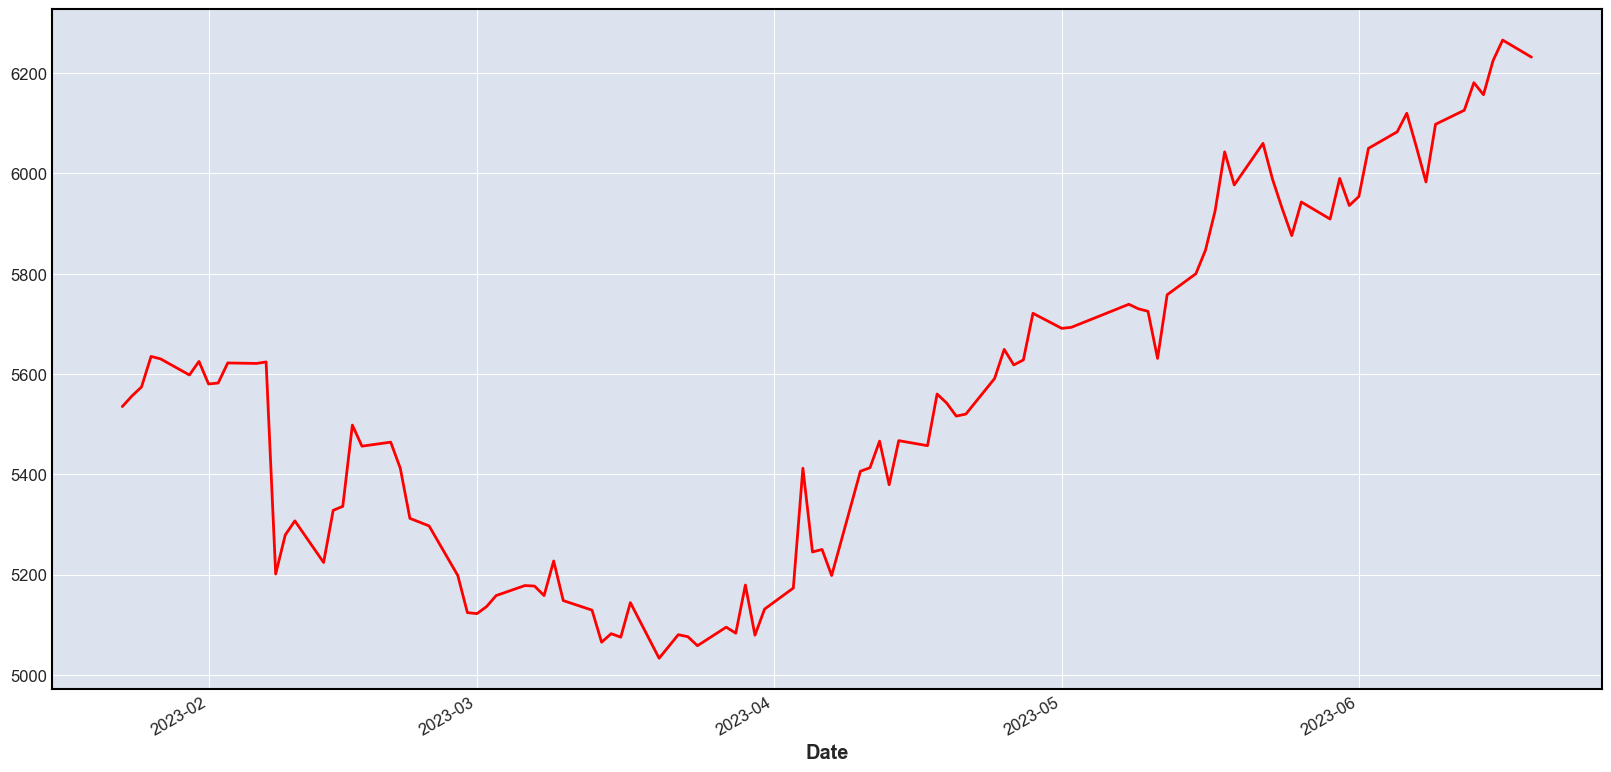

In [154]:
df["Close"].plot(figsize=(20,10), color="red")

In [155]:
# 前日と前々日の差額
df["Close"][0] - df["Close"][date]

KeyError: '2023-06-20'

In [ ]:
a = '2023-05-16'
print(date)
df["Close"][date]

2023-05-16


5847

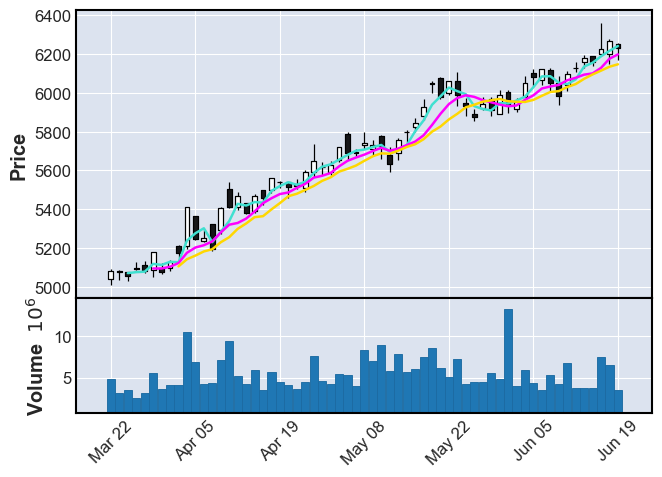

In [ ]:
dfc = df.sort_index()
mpf.plot(dfc,type='candle',mav=(3, 6, 9),volume=True)